In this notebook I fit the microburst low Earth orbit Probability Density Function (PDF) with a variety of models. The optimizer is pymc3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Define a model
First lets code up a Maxwell (Maxwell-Boltzmann) distribution.

In [2]:
def maxwell(x, a):
    """ 
    Defines a Maxwell (otherwise known as 
    Maxwell-Boltzman or Maxwellian for plasmas) 
    PDF. Independent model parameter is a. 
    The distribution is evaluated at points
    given by array x. Interesting that I did 
    not have to define theano tensor variables
    beforehand i.e. a = tt.scalar('a') and
    x = tt.vector('x') is not necessary.
    """
    inner = -x**2/(2*a**2)
    pdf = np.sqrt(2/np.pi)*(x**2/a**3)*tt.exp(inner)
    return pdf

Now confirm that our theno representation of a Maxwell distribution is the same as other sources e.g. wikipedia.

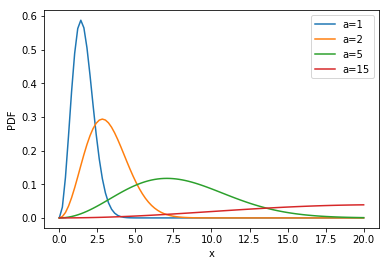

In [3]:
for a_i in [1, 2, 5, 15]:
    x = np.linspace(0, 20, num=100)
    y = maxwell(x, a_i)
    plt.plot(x, y.eval(), label=f'a={a_i}')
plt.legend()
plt.ylabel('PDF'); plt.xlabel('x');

Now lets code up a Gaussian profile

In [4]:
def gaus(x, mu, sigma):
    """ 
    
    """
    inner = -(x-mu)**2/(2*sigma**2)
    amplitude = tt.sqrt(2*np.pi*sigma**2)**(-1)
    pdf = amplitude*tt.exp(inner)
    return pdf

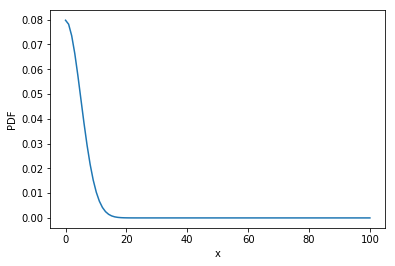

In [5]:
x = np.linspace(0, 100, num=100)
y = gaus(x, 0, 5)
plt.plot(x, y.eval())
plt.ylabel('PDF'); plt.xlabel('x');

## MCMC model

In [21]:
norm_std = 0.01

def model(x, y, dist):
    """ 
    Define a pymc3 model
    """
    with pm.Model() as model:
        # Very simple model!
        if dist == maxwell:
            a = pm.Uniform('a', lower=0, upper=20)
            y_test = dist(x, a)
        elif dist == gaus:
            mu = pm.Uniform('mu', lower=0, upper=100)
            sigma = pm.Uniform('sigma', lower=0, upper=50)
            y_test = dist(x, mu, sigma)
        # Likelihood
        c_m = pm.Normal('c_m', mu=y_test, sd=norm_std, observed=y)
        trace = pm.sample(int(1E4), tune=1000) # chains=1000, step=pm.SMC()
    return trace, c_m

### First lets fit artificial PDF to validate the model

In [7]:
a_test = 5
x = np.arange(0, 100, 5)
y = maxwell(x, a_test).eval()
y_test = np.array([np.random.normal(loc=y_i, scale=norm_std) for y_i in y])
y_test[y_test < 0] = 0

In [22]:
trace_test, c_test = model(x, y_test, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:08<00:00, 5283.80draws/s]


Now validate the models in a few ways.

In [23]:
print(f'True a = {a_test}')

True a = 5


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,4.930331,0.203539,0.00148,4.548369,5.344242,17417.009684,0.999994


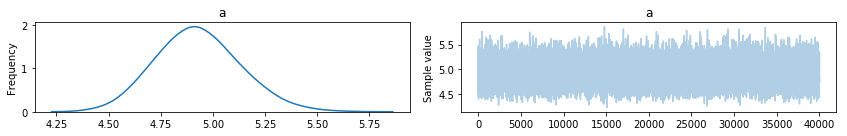

In [24]:
pm.traceplot(trace_test, combined=True);
pm.summary(trace_test)

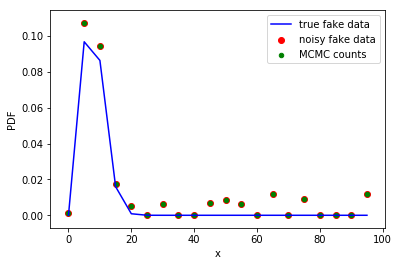

In [25]:
plt.plot(x, y, c='b', label='true fake data')
plt.scatter(x, y_test, c='r', label='noisy fake data');
plt.scatter(x, c_test.eval(), c='g', s=20, label='MCMC counts');
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF');

Now, lets load a cdf/pdf dataset that I've generated in the ./../stats/microburst_CDF.ipynb and fit a Maxwell PDF to that.

In [26]:
cdf_data = pd.read_csv('/home/mike/research/ac6_microburst_scale_sizes/data/microburst_cdf_pdf_norm_v3.csv')
cdf_data.head()

,Dist_Total,CDF,PDF
0,2.0,1.000000,0.065418
1,7.0,0.672909,0.025776
2,12.0,0.544030,0.015706
3,17.0,0.465501,0.005715
4,22.0,0.436925,0.023021


In [31]:
trace, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3682.02draws/s]
The acceptance probability does not match the target. It is 0.9950077395348699, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.158497,0.952651,0.095195,0.57467,2.870633,2.002466,30.027414


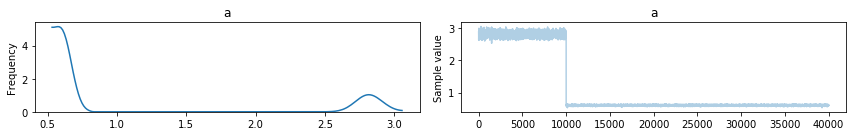

In [32]:
pm.traceplot(trace, combined=True);
pm.summary(trace)

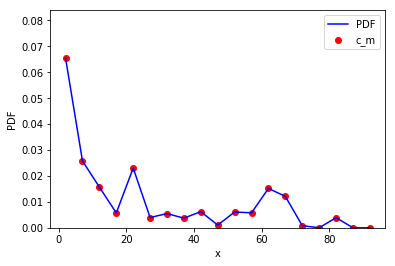

In [33]:
fig, ax = plt.subplots()
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0);

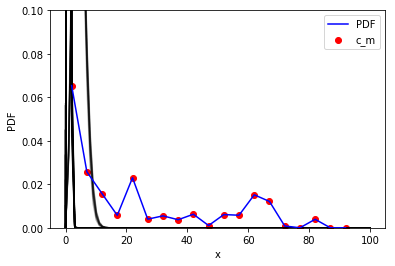

In [34]:
random_draws = np.random.choice(trace['a'], size=100)
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

for a_i in random_draws:
    ax.plot(x_plot, maxwell(x_plot, a_i).eval(), c='k', alpha=0.1)
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);

### Now try to fit a Gaussian PDF

In [48]:
trace_gaus, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, gaus)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:10<00:00, 4023.84draws/s]
The acceptance probability does not match the target. It is 0.8849331890741651, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,1.376407,1.287799,0.010146,0.000160,3.790813,14557.487734,1.000088
sigma,7.660990,2.234911,0.019739,4.432009,12.020076,9822.381623,1.000152


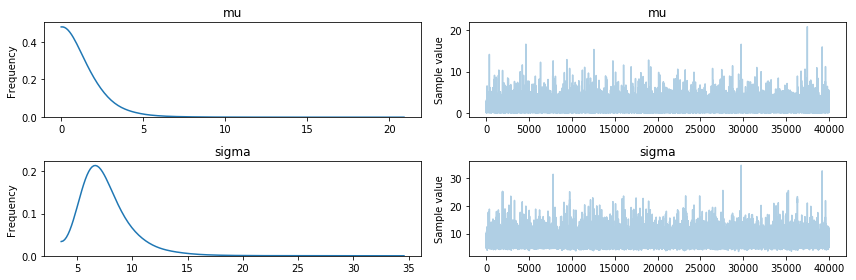

In [49]:
pm.traceplot(trace_gaus, combined=True);
pm.summary(trace_gaus)

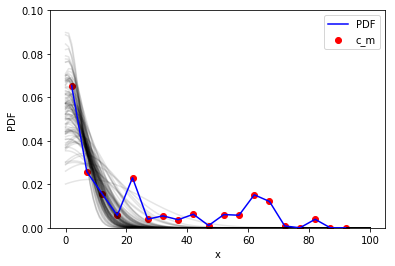

In [50]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_gaus['mu'], trace_gaus['sigma']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p]).eval(), c='k', alpha=0.1)
# Plot the raw data.
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);